In [18]:
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import json
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from model import SoundModel

### Data loading , preprocessing and labeling 

In [2]:
class SoundDataset(Dataset):
    def __init__(self, path='./data', is_train=True, is_test=False, labels_dict={}, use_normalization=True, device='cpu', student_id='42-20', test_idx=[1,2,3], n_mfcc=24, sr=22050, hop_length=512, sound_duration=3.1):
        self.path = path
        self.is_train = is_train
        self.is_test = is_test
        self.use_normalization = use_normalization
        self.device = device
        self.n_mfcc = n_mfcc
        self.sr = sr
        self.hop_length = hop_length
        self.sound_duration = sound_duration
        self.num_frames = int(np.ceil(self.sound_duration * self.sr / self.hop_length))
        self.student_id = student_id
        self.test_idx = test_idx
        self.command_dict = labels_dict
        self.preprocessed_data = []
        self.commands = []
        self._load_data()
    
    # Loading data from dir and making notation for it
    # Also preprocessing data with 
    def _load_data(self):
        cmd_int = 0
        for filename in os.listdir(self.path):        
            if filename.endswith('.wav'):
                codes = filename.split('.')[0].split('-')
                command = codes[0]
                index_year = codes[1] + '-' + codes[2]
                iteration = int(codes[3])

                # check if it is my voice and if it is certain iteration
                student_iter = (index_year == self.student_id and iteration in self.test_idx)

                # train mode and test mode have different items taken from the same dir
                if (self.is_train and not student_iter) or (not self.is_train and student_iter) or self.is_test:
                    # add command to dict
                    if command not in self.command_dict:
                        self.command_dict[command] = cmd_int
                        cmd_int += 1
                    
                    # load sound file
                    file_path = os.path.join(self.path, filename)
                    audio_data, _ = librosa.load(file_path)

                    # preprocessing
                    mfccs = librosa.feature.mfcc(y=audio_data, n_fft=2048, hop_length=self.hop_length, n_mfcc=self.n_mfcc)
                    
                    # Pad or truncate MFCCs to a fixed length (e.g., self.num_frames)
                    if mfccs.shape[1] > self.num_frames:
                        mfccs = mfccs[:, :self.num_frames]
                    elif mfccs.shape[1] < self.num_frames:
                        mfccs = np.pad(mfccs, ((0, 0), (0, self.num_frames - mfccs.shape[1])), mode='constant')

                    if self.use_normalization:
                        # Calculate mean and standard deviation along the frame axis
                        mean = np.mean(mfccs, axis=1, keepdims=True)
                        std = np.std(mfccs, axis=1, keepdims=True)

                        # Small value to avoid division by zero or near-zero
                        epsilon = 1e-6

                        # Avoid normalization when std is close to zero
                        std_safe = np.where(std < epsilon, epsilon, std)

                        # Apply normalization
                        mfccs = (mfccs - mean) / std_safe


                    self.preprocessed_data.append(mfccs)
                    self.commands.append(self.command_dict[command])
        self.n_labels = cmd_int
                

    def __len__(self):
        return len(self.preprocessed_data)
    
    def __getitem__(self, idx):
        data = torch.tensor(self.preprocessed_data[idx], dtype=torch.float32)
        label = torch.tensor(self.commands[idx], dtype=torch.long)
        label = label.to(self.device)
        data = data.to(self.device)

        return data, label

In [3]:
def plot_mfcc(mfccs):
    mfccs = mfccs.cpu().numpy()
    print(mfccs.shape)
    _, ax = plt.subplots(figsize=(10, 10))

    ax.imshow(mfccs, origin='lower', interpolation='nearest')
    plt.title('MFCC')
    plt.xlabel('Frames')
    plt.ylabel('MFCC Coefficients')
    plt.show()

In [19]:
use_normalization = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Using device {device}')

trainset = SoundDataset(is_train=True, use_normalization=False, device=device)
trainset_n = SoundDataset(is_train=True, use_normalization=True, device=device)


commands_dict = trainset.command_dict
# exporting commands dict to json
with open('commands.json', 'w') as f:
    json.dump(commands_dict, f)



valset = SoundDataset(is_train=False, use_normalization=False, device=device, labels_dict=commands_dict)
valset_n = SoundDataset(is_train=False, use_normalization=True, device=device, labels_dict=commands_dict)

Using device cuda


(24, 134)


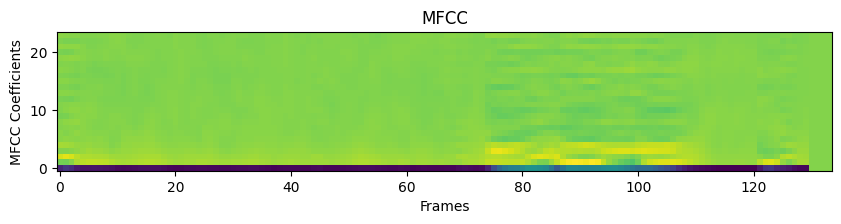

(24, 134)


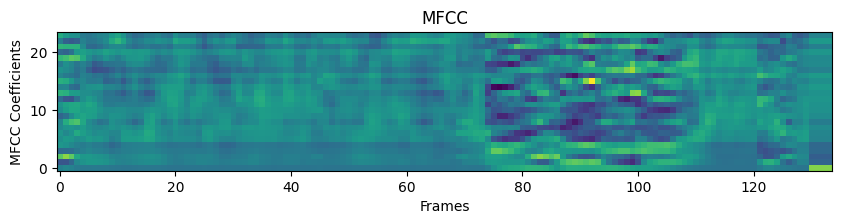

In [5]:
plot_mfcc(trainset[7][0])
plot_mfcc(trainset_n[7][0])

### Training

In [15]:
model = SoundModel(num_classes=trainset.n_labels)
model.to(device)

# Training
n_epochs = 200
batch_size = 20
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_function = nn.CrossEntropyLoss()

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=1, shuffle=False)

# Initialize variables for early stopping
best_val_loss = float('inf')
patience = 50  # Number of epochs to wait for improvement
wait = 0  # Counter for patience
best_epoch = 0

cum_train_loss = []
cum_val_loss = []

for epoch in range(n_epochs):
    train_loss = 0.0
    model.train()  # Set the model to training mode
    for batch in tqdm(trainloader):
        data, labels = batch
        optimizer.zero_grad()
        predictions = model(data)
        
        loss = loss_function(predictions, labels)
        loss.backward()
        optimizer.step()

        # detach the loss not to compute the computational graph
        train_loss += loss.detach().item()

    train_loss /= len(trainloader)    
    
    # validation
    model.eval()  # Set the model to evaluation mode
    predictions_list = []
    true_labels_list = []
    
    with torch.no_grad():
        val_loss = 0.0
        for i, batch in enumerate(valloader):
            data, labels = batch
            predictions = model(data)
            loss = loss_function(predictions, labels)
            val_loss += loss.item()

            # Store predictions and true labels for evaluation metrics
            predictions_list.extend(torch.argmax(predictions, dim=1).cpu().numpy())
            true_labels_list.extend(labels.cpu().numpy())

    val_loss /= len(valloader)

    # Calculate evaluation metric (e.g., accuracy)
    accuracy = accuracy_score(true_labels_list, predictions_list)

    print(f'Epoch {epoch + 1}/{n_epochs}, '
          f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Accuracy: {accuracy:.4f}')
    
    cum_train_loss.append(train_loss)
    cum_val_loss.append(val_loss)
    
    # Check for improvement in validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        wait = 0
        # Save model checkpoint when validation loss improves
        if epoch % 2 == 0:
            print(f'Epoch {epoch}: Saving model checkpoint ')
            torch.save(model.state_dict(), f'./models/best.pth')
    else:
        wait += 1
        if wait >= patience:
            print(f'Early stopping at epoch {epoch}. Best validation loss: {best_val_loss:.4f} at epoch {best_epoch}.')
            break  # Exit the loop if no improvement and patience reached

100%|██████████| 8/8 [00:00<00:00, 67.72it/s]


Epoch 1/200, Train Loss: 8.4118, Val Loss: 1.3590, Accuracy: 0.6000
Epoch 0: Saving model checkpoint 


100%|██████████| 8/8 [00:00<00:00, 73.00it/s]


Epoch 2/200, Train Loss: 2.2952, Val Loss: 0.9679, Accuracy: 0.6667


100%|██████████| 8/8 [00:00<00:00, 75.43it/s]


Epoch 3/200, Train Loss: 0.9480, Val Loss: 0.9322, Accuracy: 0.7333
Epoch 2: Saving model checkpoint 


100%|██████████| 8/8 [00:00<00:00, 80.80it/s]


Epoch 4/200, Train Loss: 0.8566, Val Loss: 0.7651, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00, 80.11it/s]


Epoch 5/200, Train Loss: 0.8589, Val Loss: 0.6718, Accuracy: 0.8000
Epoch 4: Saving model checkpoint 


100%|██████████| 8/8 [00:00<00:00, 80.70it/s]


Epoch 6/200, Train Loss: 0.7086, Val Loss: 0.7277, Accuracy: 0.7333


100%|██████████| 8/8 [00:00<00:00, 81.54it/s]


Epoch 7/200, Train Loss: 0.6683, Val Loss: 0.4511, Accuracy: 0.7333
Epoch 6: Saving model checkpoint 


100%|██████████| 8/8 [00:00<00:00, 81.15it/s]


Epoch 8/200, Train Loss: 0.6657, Val Loss: 0.4283, Accuracy: 0.8000


100%|██████████| 8/8 [00:00<00:00, 80.23it/s]


Epoch 9/200, Train Loss: 0.5824, Val Loss: 0.3853, Accuracy: 0.8000
Epoch 8: Saving model checkpoint 


100%|██████████| 8/8 [00:00<00:00, 81.73it/s]


Epoch 10/200, Train Loss: 0.4862, Val Loss: 0.3189, Accuracy: 0.8000


100%|██████████| 8/8 [00:00<00:00, 81.99it/s]


Epoch 11/200, Train Loss: 0.5200, Val Loss: 0.3095, Accuracy: 0.7333
Epoch 10: Saving model checkpoint 


100%|██████████| 8/8 [00:00<00:00, 80.55it/s]


Epoch 12/200, Train Loss: 0.5103, Val Loss: 0.3854, Accuracy: 0.8000


100%|██████████| 8/8 [00:00<00:00, 80.80it/s]


Epoch 13/200, Train Loss: 0.6225, Val Loss: 0.3614, Accuracy: 0.8000


100%|██████████| 8/8 [00:00<00:00, 79.06it/s]


Epoch 14/200, Train Loss: 0.5059, Val Loss: 0.3016, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 78.99it/s]


Epoch 15/200, Train Loss: 0.5922, Val Loss: 0.2766, Accuracy: 1.0000
Epoch 14: Saving model checkpoint 


100%|██████████| 8/8 [00:00<00:00, 80.51it/s]


Epoch 16/200, Train Loss: 0.5192, Val Loss: 0.2901, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 81.78it/s]


Epoch 17/200, Train Loss: 0.4864, Val Loss: 0.3576, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 81.32it/s]


Epoch 18/200, Train Loss: 0.5605, Val Loss: 0.3160, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 81.41it/s]


Epoch 19/200, Train Loss: 0.5365, Val Loss: 0.3176, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 77.78it/s]


Epoch 20/200, Train Loss: 0.4290, Val Loss: 0.3989, Accuracy: 0.8000


100%|██████████| 8/8 [00:00<00:00, 81.87it/s]


Epoch 21/200, Train Loss: 0.4894, Val Loss: 0.3544, Accuracy: 0.8000


100%|██████████| 8/8 [00:00<00:00, 80.38it/s]


Epoch 22/200, Train Loss: 0.4546, Val Loss: 0.2697, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 81.49it/s]


Epoch 23/200, Train Loss: 0.3679, Val Loss: 0.2077, Accuracy: 0.9333
Epoch 22: Saving model checkpoint 


100%|██████████| 8/8 [00:00<00:00, 78.75it/s]


Epoch 24/200, Train Loss: 0.4264, Val Loss: 0.2398, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 79.13it/s]


Epoch 25/200, Train Loss: 0.4925, Val Loss: 0.1946, Accuracy: 0.9333
Epoch 24: Saving model checkpoint 


100%|██████████| 8/8 [00:00<00:00, 78.39it/s]


Epoch 26/200, Train Loss: 0.4420, Val Loss: 0.2098, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 80.42it/s]


Epoch 27/200, Train Loss: 0.3776, Val Loss: 0.1845, Accuracy: 1.0000
Epoch 26: Saving model checkpoint 


100%|██████████| 8/8 [00:00<00:00, 80.67it/s]


Epoch 28/200, Train Loss: 0.3794, Val Loss: 0.1680, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 79.90it/s]


Epoch 29/200, Train Loss: 0.3627, Val Loss: 0.1665, Accuracy: 1.0000
Epoch 28: Saving model checkpoint 


100%|██████████| 8/8 [00:00<00:00, 79.92it/s]


Epoch 30/200, Train Loss: 0.3468, Val Loss: 0.1829, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 80.06it/s]


Epoch 31/200, Train Loss: 0.3891, Val Loss: 0.1739, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 80.60it/s]


Epoch 32/200, Train Loss: 0.4292, Val Loss: 0.1374, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 80.77it/s]


Epoch 33/200, Train Loss: 0.4963, Val Loss: 0.1281, Accuracy: 0.9333
Epoch 32: Saving model checkpoint 


100%|██████████| 8/8 [00:00<00:00, 81.39it/s]


Epoch 34/200, Train Loss: 0.3159, Val Loss: 0.1502, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 80.97it/s]


Epoch 35/200, Train Loss: 0.4069, Val Loss: 0.2050, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 81.37it/s]


Epoch 36/200, Train Loss: 0.3720, Val Loss: 0.1930, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 80.97it/s]


Epoch 37/200, Train Loss: 0.3090, Val Loss: 0.1148, Accuracy: 1.0000
Epoch 36: Saving model checkpoint 


100%|██████████| 8/8 [00:00<00:00, 80.59it/s]


Epoch 38/200, Train Loss: 0.3170, Val Loss: 0.1472, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 80.32it/s]


Epoch 39/200, Train Loss: 0.3512, Val Loss: 0.5751, Accuracy: 0.8000


100%|██████████| 8/8 [00:00<00:00, 80.33it/s]


Epoch 40/200, Train Loss: 0.3647, Val Loss: 0.3087, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00, 78.10it/s]


Epoch 41/200, Train Loss: 0.3251, Val Loss: 0.6100, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00, 79.85it/s]


Epoch 42/200, Train Loss: 0.3687, Val Loss: 0.2445, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 81.71it/s]


Epoch 43/200, Train Loss: 0.3044, Val Loss: 0.2803, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 80.98it/s]


Epoch 44/200, Train Loss: 0.2790, Val Loss: 0.1615, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 80.80it/s]


Epoch 45/200, Train Loss: 0.3096, Val Loss: 0.2461, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 80.50it/s]


Epoch 46/200, Train Loss: 0.2920, Val Loss: 0.2535, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 81.39it/s]


Epoch 47/200, Train Loss: 0.3662, Val Loss: 0.2217, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 81.79it/s]


Epoch 48/200, Train Loss: 0.3293, Val Loss: 0.1934, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 80.33it/s]


Epoch 49/200, Train Loss: 0.3819, Val Loss: 0.1389, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 80.81it/s]


Epoch 50/200, Train Loss: 0.2657, Val Loss: 0.1367, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 80.68it/s]


Epoch 51/200, Train Loss: 0.2351, Val Loss: 0.1539, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 77.18it/s]


Epoch 52/200, Train Loss: 0.2654, Val Loss: 0.1913, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 80.79it/s]


Epoch 53/200, Train Loss: 0.2398, Val Loss: 0.2018, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00, 80.31it/s]


Epoch 54/200, Train Loss: 0.1976, Val Loss: 0.2127, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00, 80.69it/s]


Epoch 55/200, Train Loss: 0.1601, Val Loss: 0.4825, Accuracy: 0.8000


100%|██████████| 8/8 [00:00<00:00, 80.87it/s]


Epoch 56/200, Train Loss: 0.2466, Val Loss: 0.2110, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 80.99it/s]


Epoch 57/200, Train Loss: 0.2644, Val Loss: 0.3810, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 80.37it/s]


Epoch 58/200, Train Loss: 0.2567, Val Loss: 0.1221, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 79.90it/s]


Epoch 59/200, Train Loss: 0.2114, Val Loss: 0.1355, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00, 80.42it/s]


Epoch 60/200, Train Loss: 0.1644, Val Loss: 0.1693, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00, 81.33it/s]


Epoch 61/200, Train Loss: 0.1451, Val Loss: 0.1826, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00, 80.59it/s]


Epoch 62/200, Train Loss: 0.1643, Val Loss: 0.1208, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00, 78.49it/s]


Epoch 63/200, Train Loss: 0.3091, Val Loss: 0.0789, Accuracy: 0.9333
Epoch 62: Saving model checkpoint 


100%|██████████| 8/8 [00:00<00:00, 80.68it/s]


Epoch 64/200, Train Loss: 0.2064, Val Loss: 0.1938, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 80.96it/s]


Epoch 65/200, Train Loss: 0.2807, Val Loss: 0.2260, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 81.32it/s]


Epoch 66/200, Train Loss: 0.2433, Val Loss: 0.1263, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00, 81.50it/s]


Epoch 67/200, Train Loss: 0.1641, Val Loss: 0.0143, Accuracy: 1.0000
Epoch 66: Saving model checkpoint 


100%|██████████| 8/8 [00:00<00:00, 81.17it/s]


Epoch 68/200, Train Loss: 0.1701, Val Loss: 0.0097, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 81.74it/s]


Epoch 69/200, Train Loss: 0.1647, Val Loss: 0.0130, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 79.03it/s]


Epoch 70/200, Train Loss: 0.1899, Val Loss: 0.0147, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 80.38it/s]


Epoch 71/200, Train Loss: 0.1944, Val Loss: 0.0265, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 79.87it/s]


Epoch 72/200, Train Loss: 0.1777, Val Loss: 0.0242, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 78.43it/s]


Epoch 73/200, Train Loss: 0.2031, Val Loss: 0.0957, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 78.40it/s]


Epoch 74/200, Train Loss: 0.2946, Val Loss: 0.0210, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 80.11it/s]


Epoch 75/200, Train Loss: 0.1389, Val Loss: 0.0209, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 81.06it/s]


Epoch 76/200, Train Loss: 0.1786, Val Loss: 0.0279, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 78.12it/s]


Epoch 77/200, Train Loss: 0.2754, Val Loss: 0.0420, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 80.39it/s]


Epoch 78/200, Train Loss: 0.1858, Val Loss: 0.0610, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 81.05it/s]


Epoch 79/200, Train Loss: 0.1596, Val Loss: 0.0726, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 80.31it/s]


Epoch 80/200, Train Loss: 0.1630, Val Loss: 0.0536, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 80.18it/s]


Epoch 81/200, Train Loss: 0.1468, Val Loss: 0.0487, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 81.05it/s]


Epoch 82/200, Train Loss: 0.1890, Val Loss: 0.1157, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 79.94it/s]


Epoch 83/200, Train Loss: 0.1732, Val Loss: 0.1917, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 80.05it/s]


Epoch 84/200, Train Loss: 0.1818, Val Loss: 0.1885, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 78.47it/s]


Epoch 85/200, Train Loss: 0.1508, Val Loss: 0.1513, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 81.15it/s]


Epoch 86/200, Train Loss: 0.1391, Val Loss: 0.1073, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 80.96it/s]


Epoch 87/200, Train Loss: 0.1197, Val Loss: 0.0898, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 80.68it/s]


Epoch 88/200, Train Loss: 0.1671, Val Loss: 0.1273, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 82.13it/s]


Epoch 89/200, Train Loss: 0.1609, Val Loss: 0.1600, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 80.83it/s]


Epoch 90/200, Train Loss: 0.1202, Val Loss: 0.1585, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 80.10it/s]


Epoch 91/200, Train Loss: 0.1503, Val Loss: 0.1395, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 79.78it/s]


Epoch 92/200, Train Loss: 0.1530, Val Loss: 0.1359, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 78.89it/s]


Epoch 93/200, Train Loss: 0.1535, Val Loss: 0.1409, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 78.35it/s]


Epoch 94/200, Train Loss: 0.0931, Val Loss: 0.1406, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 80.10it/s]


Epoch 95/200, Train Loss: 0.1686, Val Loss: 0.1462, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00, 80.31it/s]


Epoch 96/200, Train Loss: 0.1343, Val Loss: 0.1742, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00, 80.83it/s]


Epoch 97/200, Train Loss: 0.1343, Val Loss: 0.1940, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00, 80.23it/s]


Epoch 98/200, Train Loss: 0.1072, Val Loss: 0.1931, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00, 80.02it/s]


Epoch 99/200, Train Loss: 0.0519, Val Loss: 0.1741, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00, 80.18it/s]


Epoch 100/200, Train Loss: 0.1845, Val Loss: 0.1484, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00, 81.07it/s]


Epoch 101/200, Train Loss: 0.1058, Val Loss: 0.1327, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 80.05it/s]


Epoch 102/200, Train Loss: 0.0900, Val Loss: 0.1189, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 78.43it/s]


Epoch 103/200, Train Loss: 0.0878, Val Loss: 0.1106, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 78.31it/s]


Epoch 104/200, Train Loss: 0.1164, Val Loss: 0.0941, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 77.21it/s]


Epoch 105/200, Train Loss: 0.1277, Val Loss: 0.0942, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 80.86it/s]


Epoch 106/200, Train Loss: 0.0846, Val Loss: 0.1167, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00, 78.64it/s]


Epoch 107/200, Train Loss: 0.0831, Val Loss: 0.0903, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 81.33it/s]


Epoch 108/200, Train Loss: 0.1503, Val Loss: 0.0762, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 81.24it/s]


Epoch 109/200, Train Loss: 0.0697, Val Loss: 0.1098, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 80.95it/s]


Epoch 110/200, Train Loss: 0.2568, Val Loss: 0.1186, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 78.63it/s]


Epoch 111/200, Train Loss: 0.1020, Val Loss: 0.1240, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 78.88it/s]


Epoch 112/200, Train Loss: 0.0912, Val Loss: 0.0975, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 80.61it/s]


Epoch 113/200, Train Loss: 0.1081, Val Loss: 0.0862, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 80.85it/s]


Epoch 114/200, Train Loss: 0.1225, Val Loss: 0.0755, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 80.80it/s]


Epoch 115/200, Train Loss: 0.0887, Val Loss: 0.0707, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 79.07it/s]


Epoch 116/200, Train Loss: 0.0821, Val Loss: 0.0654, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 81.20it/s]


Epoch 117/200, Train Loss: 0.0888, Val Loss: 0.0607, Accuracy: 1.0000


100%|██████████| 8/8 [00:00<00:00, 80.45it/s]

Epoch 118/200, Train Loss: 0.1093, Val Loss: 0.0574, Accuracy: 1.0000
Early stopping at epoch 117. Best validation loss: 0.0097 at epoch 67.


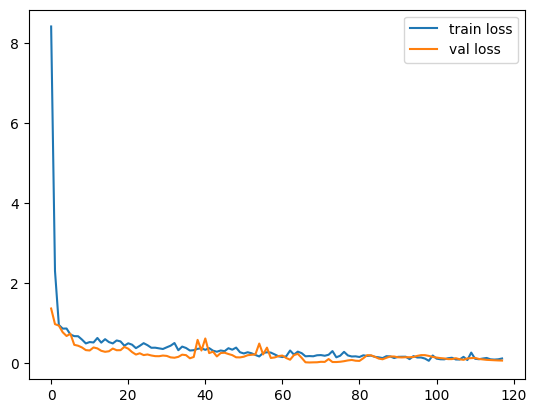

In [16]:
# plot train and val loss on the same axis

plt.plot(cum_train_loss, label='train loss')
plt.plot(cum_val_loss, label='val loss')
plt.legend()
plt.show()

In [13]:
def idx_to_cmd(idx, commands_dict):
    for cmd, cmd_idx in commands_dict.items():
        if cmd_idx == idx:
            return cmd
    return None

In [17]:
# if model doesnt exist make it
model = SoundModel(num_classes=trainset.n_labels)
model.to(device)

model.load_state_dict(torch.load('./models/best.pth'))
testset = SoundDataset(path='./test_data', is_test=True,  use_normalization=False, device=device, labels_dict=commands_dict)

print(f'Commands: {testset.command_dict}')
print('------------------')
model.eval()

different = 0
for data, label in testset:
    data = data.unsqueeze(0)
    with torch.no_grad():
        predictions = model(data)
        if torch.argmax(predictions, dim=1) != label:
            different += 1
        print(f'True command: {idx_to_cmd(label, commands_dict)}')
        print(f'Predicted command: {idx_to_cmd(torch.argmax(predictions, dim=1), commands_dict)}')
        print('------------------')
print(f"different: {different}")


Commands: {'kvadrat': 0, 'oboji': 1, 'izbrisi': 2, 'trougao': 3, 'krug': 4}
------------------
True command: krug
Predicted command: krug
------------------
True command: oboji
Predicted command: oboji
------------------
True command: oboji
Predicted command: oboji
------------------
True command: izbrisi
Predicted command: izbrisi
------------------
True command: trougao
Predicted command: oboji
------------------
True command: kvadrat
Predicted command: kvadrat
------------------
True command: izbrisi
Predicted command: izbrisi
------------------
True command: krug
Predicted command: krug
------------------
True command: krug
Predicted command: oboji
------------------
True command: kvadrat
Predicted command: kvadrat
------------------
True command: trougao
Predicted command: trougao
------------------
True command: kvadrat
Predicted command: kvadrat
------------------
True command: oboji
Predicted command: oboji
------------------
True command: trougao
Predicted command: trougao
---